# Predict ETH price direction - Random Forest Classifier

In [103]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime 

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [104]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_6.csv', parse_dates=True)

In [105]:
# Read in combined ETH Google trends data
eth_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_google_trends/eth_trends_combined.csv', parse_dates=True)
eth_google_trends.reset_index(inplace=True)
eth_google_trends.rename(columns={'date':'time', 'ethereum':'ETH_Trends'},inplace=True)
eth_google_trends = eth_google_trends.drop(columns='index')
eth_google_trends['time'] = pd.to_datetime(eth_google_trends['time']).dt.date
eth_google_trends = eth_google_trends.set_index('time')
eth_google_trends.head()

,ETH_Trends
time,
2016-01-01,8
2016-01-02,4
2016-01-03,4
2016-01-04,5
2016-01-05,8


In [106]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')

In [107]:
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [108]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
time,,,,,,,,,,,
2016-01-01,eth,2433,2.166056,7.010116e+07,0.483217,264.814266,0.920370,7.616628e+07,8233,264718.210777,1.362126
2016-01-02,eth,2486,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164,195513.065884,1.365054
2016-01-03,eth,2528,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258,311464.489292,1.369430
2016-01-04,eth,2623,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474,115686.914897,1.370961
2016-01-05,eth,2620,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430,645005.606026,1.384049


In [109]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,eth_google_trends],axis=1)
combined_df =combined_df.dropna()
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends
2016-01-01,eth,2433.0,2.166056,7.010116e+07,0.483217,264.814266,0.920370,7.616628e+07,8233.0,264718.210777,1.362126,8
2016-01-02,eth,2486.0,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164.0,195513.065884,1.365054,4
2016-01-03,eth,2528.0,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258.0,311464.489292,1.369430,4
2016-01-04,eth,2623.0,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474.0,115686.914897,1.370961,5
2016-01-05,eth,2620.0,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430.0,645005.606026,1.384049,8


In [110]:
combined_df.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_metrics_combined.csv')

<AxesSubplot:title={'center':'EMA ETH'}, ylabel='ETH Price ($)'>

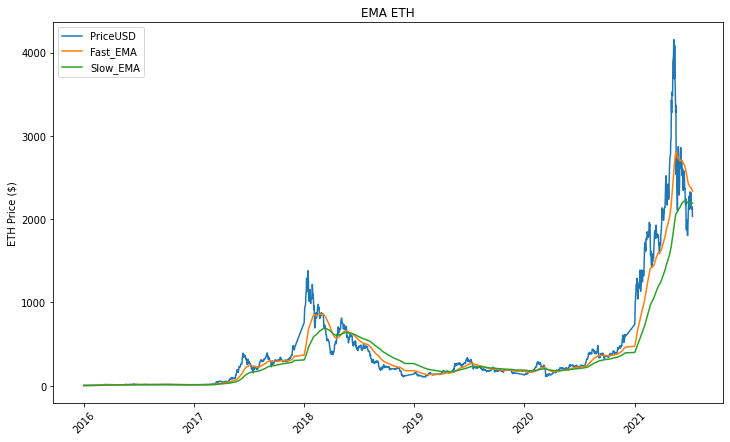

In [111]:
# Set short and long windows for EMA (Exponential Moving Average)
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
combined_df['Fast_EMA'] = combined_df['PriceUSD'].ewm(halflife=short_window).mean()
combined_df['Slow_EMA'] = combined_df['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
combined_df[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA ETH', ylabel='ETH Price ($)', rot=45) 

In [112]:
# Construct a crossover trading signal
combined_df['Crossover_Long'] = np.where(combined_df['Fast_EMA'] > combined_df['Slow_EMA'], 1.0, 0.0)
combined_df['Crossover_Short'] = np.where(combined_df['Fast_EMA'] < combined_df['Slow_EMA'],-1.0, 0.0)
combined_df['Crossover_Signal'] = combined_df['Crossover_Long'] + combined_df['Crossover_Short']

In [113]:
# Calculate daily return
combined_df['Daily_Return'] = combined_df['PriceUSD'].pct_change()

In [114]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
combined_df['Positive_Return'] = np.where(combined_df['Daily_Return'] > 0, 1.0, 0.0)

combined_df = combined_df.dropna()

# Convert date to str to set test and train windows 
combined_df.index = pd.to_datetime(combined_df.index, format = '%Y/%m/%d')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
2016-01-02,eth,2486.0,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164.0,195513.065884,1.365054,4,0.935437,0.935283,1.0,0.0,1.0,0.032183,1.0
2016-01-03,eth,2528.0,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258.0,311464.489292,1.369430,4,0.942897,0.942644,1.0,0.0,1.0,0.007445,1.0
2016-01-04,eth,2623.0,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474.0,115686.914897,1.370961,5,0.944766,0.944521,1.0,0.0,1.0,-0.007380,0.0
2016-01-05,eth,2620.0,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430.0,645005.606026,1.384049,8,0.944302,0.944126,1.0,0.0,1.0,-0.007789,0.0
2016-01-06,eth,2743.0,2.227748,7.248901e+07,0.496250,159.111072,0.950000,7.630422e+07,17074.0,455587.485546,1.390600,8,0.945336,0.945139,1.0,0.0,1.0,0.007851,1.0


In [118]:
# Select model features and timeframe for train data
X = combined_df[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','ETH_Trends']]
X_train = X.loc[:'2020']

In [119]:
# Select prediction variable and timeframe for train data
y = combined_df['Positive_Return']
y_train = y[:'2020']

In [120]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [121]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [122]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [123]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [124]:
# Create the decision tree classifier instance and calculate the optimal tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))


Best: 0.523980 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}


In [125]:
# Define the model using optimized settings
model = RandomForestClassifier(criterion='gini', max_depth=10,n_estimators=500, n_jobs=-1)

In [128]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [129]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [130]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [131]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,51,34
Actual 1,48,60


Accuracy Score : 0.5751295336787565
Classification Report
              precision    recall  f1-score   support

         0.0       0.52      0.60      0.55        85
         1.0       0.64      0.56      0.59       108

    accuracy                           0.58       193
   macro avg       0.58      0.58      0.57       193
weighted avg       0.58      0.58      0.58       193



In [133]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-30:]

,Positive_Return,Predicted Value
2021-06-13,1.0,1.0
2021-06-14,1.0,1.0
2021-06-15,0.0,1.0
2021-06-16,0.0,0.0
2021-06-17,1.0,0.0
2021-06-18,0.0,0.0
2021-06-19,0.0,0.0
2021-06-20,1.0,1.0
2021-06-21,0.0,0.0
2021-06-22,0.0,0.0


In [134]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)[:10]

[(0.13624537226029798, 'CapMVRVCur'),
 (0.11660114476502044, 'NVTAdj'),
 (0.1130546148451545, 'TxCnt'),
 (0.11139111517565235, 'CapMrktCurUSD'),
 (0.10996141455451214, 'AdrActCnt'),
 (0.107142504359442, 'VelCur1yr'),
 (0.10617428681513914, 'HashRate'),
 (0.10522264858696365, 'TxTfrValAdjUSD'),
 (0.08888382914857673, 'ETH_Trends'),
 (0.005323069489241021, 'Crossover_Signal')]

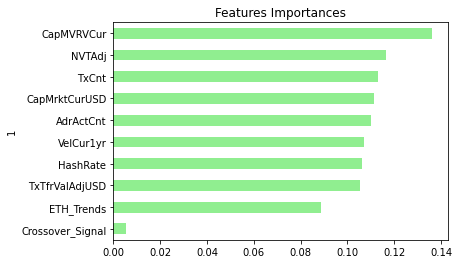

In [135]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))[:10]
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)